<span style="float: left;padding: 1.3em">![logo](https://raw.githubusercontent.com/inaki-ortizdelandaluce/relatividad-general-2025/main/notebooks/logo.png)</span>

# Análisis de datos de Ondas Gravitacionales

## Módulo 2: Introducción a GWpy

Este notebook es un módulo de introducción a GWpy, un paquete Python de astrofísica gravitacional que puedes usar para acceder y procesar datos disponibles públicamente desde el [Gravitational-Wave Open Science Center (GWOSC)](https://gwosc.org).


<a href="https://colab.research.google.com/github/inaki-ortizdelandaluce/relatividad-general-2025/blob/main/notebooks/GR25-02-Introduccion_a_GWpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Instalación

Ejecuta las siguientes dos líneas para evitar mensajes innecesarios cuando importéis algunos paquetes:

In [2]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

> ⚠️ **Advertencia**: Reinicia el notebook una vez que ejecutes la siguiente celda.
>
> Para reiniciar el notebook en Google Colab, pulsa en la barra de herramientas el menú "Runtime" y selecciona "Restart session and run all".

In [4]:
# -- Uncomment following line if running in Google Colab or first time local installation in Jupyter
#! pip install -q 'gwpy==3.0.12'

In [5]:
# The first import of gwpy can take some time (especially on cloud platforms).
# This is mainly due to matplotlib taking some time to import (this is normal).
import gwpy
print(gwpy.__version__)

3.0.12


## Introducción

Antes de profundizar en los contenidos del módulo, vale la pena hacer una breve digresión sobre la programación orientada a objetos. [GWpy](https://gwpy.github.io/docs/stable/index.html) está fuertemente orientado a objetos, lo que significa que casi todo el código que ejecutes usando GWpy se basa en un objeto de algún tipo, por ejemplo, `TimeSeries`. La mayoría de los métodos (funciones) que usaremos están asociados a un objeto, en lugar de ser independientes. Esto significa que deberías tener una idea bastante clara del tipo de datos con el que estás tratando (¡sin tener que leer la documentación!).

Para una descripción general rápida de la programación orientada a objetos en Python, consulta esta [entrada de blog de Jeff Knupp](https://medium.com/hackernoon/improve-your-python-python-classes-and-object-oriented-programming-d09ff461168d).

## Manejando datos de series temporales

#### Búsqueda de datos públicos

Ya hemos visto en el módulo anterior que el paquete Python `gwosc` puede utilizarse para consultar qué datos están disponibles en [GWOSC](https://gwosc.org/data/). El siguiente paso es leer algunos de estos datos abiertos. Intentemos obtenerlos para el evento GW190412, la primera detección de una señal de onda gravitacional proveniente de un Sistema Binario de Agujeros Negros (Binary Black Hole ó BBH) con masas significativamente desiguales.

Podemos utilizar el método [TimeSeries.fetch_open_data](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries/#gwpy.timeseries.TimeSeries.fetch_open_data) para descargar datos directamente desde https://gwosc.org, pero necesitamos conocer los tiempos GPS. Como ya vimos en el módulo anterior, podemos consultar el tiempo GPS de un evento de la siguiente manera:

In [6]:
from gwosc.datasets import event_gps
gps = event_gps('GW190412')
print(gps)

1239082262.1


Ahora podemos construir un segmento GPS `[start, end)` de 10 segundos alrededor de este tiempo, usando enteros para mayor comodidad:

In [7]:
segment = (int(gps)-5, int(gps)+5)
print(segment)

(1239082257, 1239082267)


Y ahora podemos solicitar los datos completos. Para este ejemplo, elegimos recuperar datos del interferómetro LIGO-Livingston, utilizando el identificador 'L1'. Podríamos haber elegido cualquiera de los siguientes detectores:

- `'G1'` - GEO600
- `'H1'` - LIGO-Hanford
- `'L1'` - LIGO-Livingston
- `'V1'` - (Advanced) Virgo
- `'K1'` - KAGRA


In [8]:
from gwpy.timeseries import TimeSeries
ldata = TimeSeries.fetch_open_data('L1', *segment, verbose=True)
print(ldata)

Fetched 1 URLs from gwosc.org for [1239082257 .. 1239082267))
Reading data... [Done]
TimeSeries([-8.42597565e-19, -8.52437103e-19, -8.60738804e-19,
            ...,  1.38850270e-19,  1.37760541e-19,
             1.38094202e-19]
           unit: dimensionless,
           t0: 1239082257.0 s,
           dt: 0.000244140625 s,
           name: Strain,
           channel: None)


##### La opción `verbose=True` nos permite ver que GWpy ha encontrado un archivo que proporciona los datos para el intervalo dado, lo ha descargado y ha cargado los datos.

Los archivos no se almacenan de forma permanente, por lo que la próxima vez que realices la misma llamada, se volverá a descargar. Sin embargo, si sabes que podrías repetir la misma llamada muchas veces, puedes usar `cache=True` para almacenar el archivo en tu computadora.


Notas:

* El operador asterisco `*` se usa en Python cuando queremos desempaquetar los elementos individuales de una lista o tupla. De esta manera, el agumento `*segment` desempaqueta los valores `(start, end)` en valores individuales que pasa al método `fetch_open_data('L1', 1239082257, 1239082267, verbose=True)`.
  
* Para controlar el _dataset_ del que provienen tus datos, puedes usar el argumento `dataset`. Es recomendable utilizar datos de una campaña de observación, si están disponibles, porque contienen la versión más actualizada de la calibración. Para verificar qué campaña de observación estaba activa en el tiempo que deseas consultar, basta con usar el método `find_datasets` del paquete `gwosc` que hemos visto en el módulo anterior, especificando (`type='run', segment=segment`). Por ejemplo, para el segmento que estamos usando en este módulo, los dos _datasets_ disponibles son [`'O3a_16KHZ_R1'`, `'O3a_4KHZ_R1'`]. Para el muestreo a 4 kHz, el comando completo para obtener datos de este conjunto de datos es: `TimeSeries.fetch_open_data('L1', *segment, verbose=True, dataset='O3a_4KHZ_R1')`.

* Para leer datos desde un archivo local en lugar del servidor GWOSC, podemos usar el método [`TimeSeries.read`](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries/#gwpy.timeseries.TimeSeries.read).

¡Ahora hemos descargado datos reales de LIGO para GW190412! Estos son los datos reales utilizados en el análisis de esta coalescencia de agujeros negros binarios.

Para verificar que todo ha ido bien, podemos hacer una representación greafica de los datos usando el método [`plot()`](https://gwpy.github.io/docs/stable/plot/) del objeto `data` de la clase `TimeSeries`.

<div class="alert alert-info">
Como es la primera vez que estamos representando gráficamente algunos datos en este notebook, necesitamos configurar `matplotlib` (la librería de representación grafica estándar en Python) para que todo funcione correctamente:
</div>

La documentación de Matplotlib se puede consultar [aquí](https://matplotlib.org/stable/users/index.html).

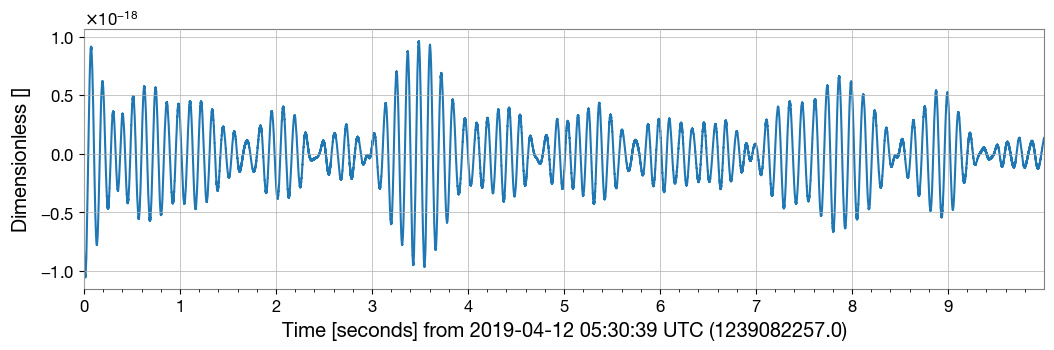

In [12]:
plot = ldata.plot()

Nota: Hay métodos alternativos para acceder a los datos de GWOSC. Por ejemplo, el paquete de Python [PyCBC](https:/pycbc.org) incluye las funciones `pycbc.frame.query_and_read_frame` y `pycbc.frame.read_frame` que aprenderemos próximamente.

## Manejando datos en el dominio de frecuencias usando la transformada de Fourier

La [transformada de Fourier](https://en.wikipedia.org/wiki/Fourier_transform) es una herramienta matemática ampliamente utilizada para exponer el contenido en el dominio de la frecuencia de una señal en el dominio del tiempo, lo que nos permite ver qué frecuencias contienen mucha potencia y cuáles tienen menos.

Podemos calcular la transformada de Fourier de nuestra serie temporal `TimeSeries` utilizando el método [fft()](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries/?highlight=fourier#gwpy.timeseries.TimeSeries.fft):

In [13]:
fft = ldata.fft()
print(fft)

FrequencySeries([-1.45894410e-21+0.00000000e+00j,
                 -2.91834926e-21-4.52905657e-23j,
                 -2.91973330e-21-9.06202944e-23j, ...,
                 -2.38723982e-23+4.67871178e-26j,
                 -2.38345362e-23+1.80394058e-26j,
                 -2.38457175e-23+0.00000000e+00j]
                unit: dimensionless,
                f0: 0.0 Hz,
                df: 0.1 Hz,
                epoch: 1239082257.0,
                name: Strain,
                channel: None)


El resultado es una serie de frecuencias, [`FrequencySeries`](https://gwpy.github.io/docs/stable/api/gwpy.frequencyseries.FrequencySeries/#gwpy.frequencyseries.FrequencySeries), con valor complejo, que representa la amplitud y la fase de cada frecuencia en nuestros datos. Podemos usar abs() para extraer la amplitud y representarla gráficamente:

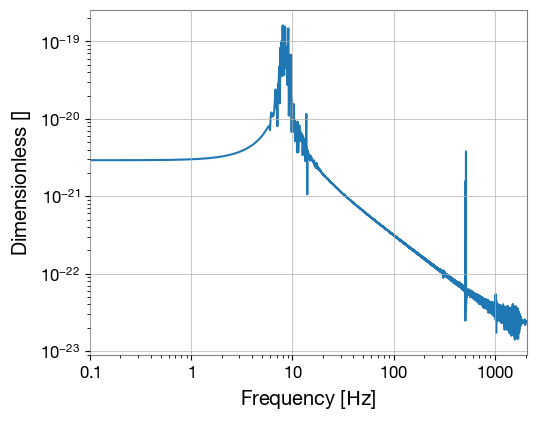

In [14]:
plot = fft.abs().plot(xscale="log", yscale="log")
plot.show(warn=False)

Como podemos ver, el resultado no parece correcto. El problema es que la Transformada Rápida de Fourier (Fast Fourier Transform ó FFT) funciona bajo el supuesto de que nuestros datos son periódicos, lo que significa que los bordes de nuestros datos se ven como discontinuidades cuando se transforman.

Necesitamos aplicar una función de ventana a nuestros datos en el dominio del tiempo antes de transformarlos, lo cual podemos hacer utilizando el módulo [`scipy.signal`](https://docs.scipy.org/doc/scipy/reference/signal.html):

In [15]:
from scipy.signal import get_window
window = get_window('hann', ldata.size)
lwin = ldata * window

Intentemos nuestra transformación nuevamente con los datos ya enmarcados y veamos qué obtenemos:

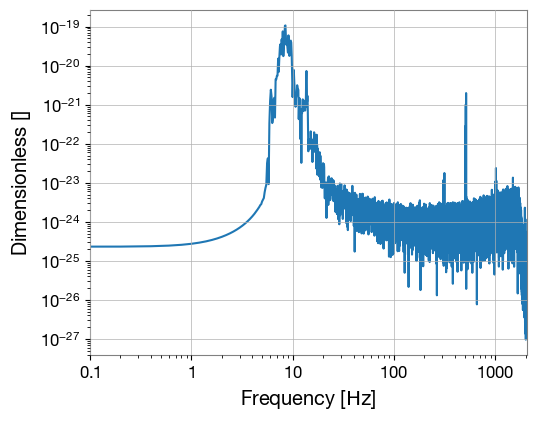

In [16]:
fftamp = lwin.fft().abs()
plot = fftamp.plot(xscale="log", yscale="log")
plot.show(warn=False)

Esto se parece un poco más a lo que esperamos para la densidad espectral de amplitud de un detector de ondas gravitacionales.

## Estimando la densidad espectral de potencia

Las fluctuaciones en la gráfica anterior en frecuencias superiores a 10 Hz parecen completamente aleatorias. Esto es efectivamente el ruido intrínseco en la estimación del contenido espectral de la señal a partir de una única FFT. Podemos reducir estas fluctuaciones promediando muchas estimaciones de la FFT de la señal. Pero, siendo los componentes de la FFT cantidades complejas, lo que realmente queremos promediar son sus módulos al cuadrado. Esta cantidad se denomina [Densidad Espectral de Potencia (Powe Spectral Density ó PSD)](https://en.wikipedia.org/wiki/Spectral_density), y lo que acabamos de describir es el [método de estimación de Welch](https://en.wikipedia.org/wiki/Welch%27s_method). También es conveniente expresar el resultado no como potencia sino como amplitud, tomando la raíz cuadrada de la expresión anterior. La cantidad resultante recibe el nombre de Densidad Espectral de Amplitud (Amplitude Spectral Density ó ASD) de la señal.

La biblioteca GWpy proporciona el método [`asd()`](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries/?highlight=asd#gwpy.timeseries.TimeSeries.asd) en la clase `TimeSeries`, que utiliza la técnica anterior para combinar FFTs estimadas en segmentos superpuestos y enmarcados de datos.

Alternativamente, se podrían haber combinado las diversas estimaciones de FFT calculando su mediana, que es una estadística más robusta que la media implementada en el método de Welch con respecto a fluctuaciones espurias del nivel de la señal.

El método `asd()` en GWpy acepta tanto `'median'` como `'welch'` como métodos posibles para estimar la ASD de una señal.

Explora la diferencia en el resultado de la estimación de ASD cambiando los valores de los parámetros `fftlength` (la duración en segundos de los datos utilizados para estimar cada FFT) y el método utilizado para promediarlos. Puedes echar también un vistazo a los demás [parámetros opcionales](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries/#gwpy.timeseries.TimeSeries.asd-parameters).

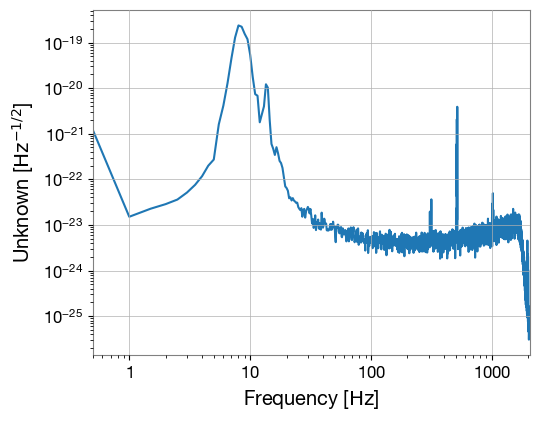

In [17]:
asd = ldata.asd(fftlength=2, method="median")
plot = asd.plot()
plot.show(warn=False)

Podemos personalizar esta figura ampliando el rango de frecuencia de interés, es decir, por encima del "hombro" de ruido sísmico a 10 Hz y por debajo del corte en la frecuencia de Nyquist, y redimensionando el eje y en consecuencia.

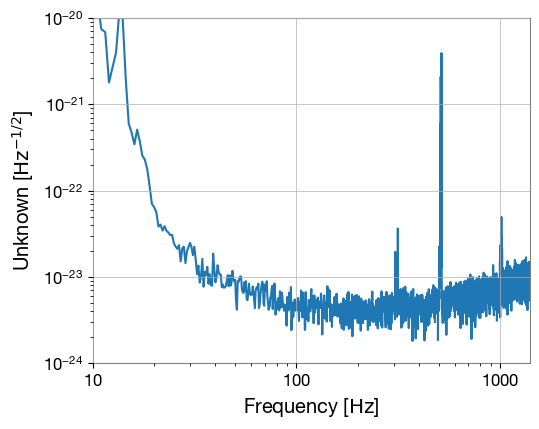

In [19]:
ax = plot.gca()
ax.set(xlim=(10, 1400), ylim=(1e-24, 1e-20))
plot

La Densidad Espectral de Amplitud (ASD) es una herramienta estándar utilizada para estudiar la sensibilidad en el dominio de la frecuencia de un detector de ondas gravitacionales. Para los datos de LIGO-Livingston que cargamos, podemos observar grandes picos en ciertas frecuencias, incluyendo:

~300 Hz

~500 Hz

~1000 Hz

La página de [líneas espectrales de O3](https://gwosc.org/O3/o3aspeclines/) en GWOSC describe varias de estas características espectrales para O3, donde algunas son impuestas por condiciones externas y otras son introducidas deliberadamente para ayudar con el control del interferómetro.

Cargar más datos permite promediar más FFT durante la estimación de la ASD, lo que significa que las variaciones aleatorias se promedian y podemos ver más detalles:

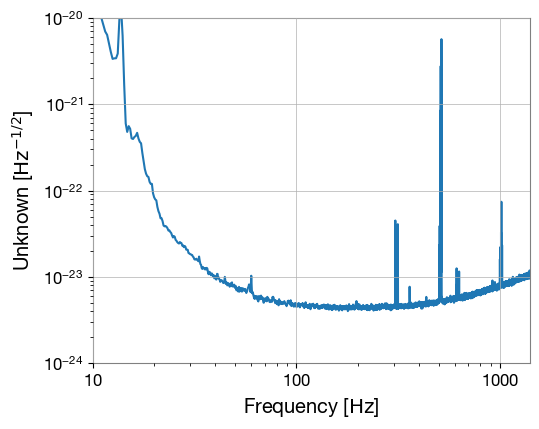

In [20]:
ldata2 = TimeSeries.fetch_open_data('L1', int(gps)-512, int(gps)+512, cache=True)
lasd2 = ldata2.asd(fftlength=4, method="median")
plot = lasd2.plot()
ax = plot.gca()
ax.set_xlim(10, 1400)
ax.set_ylim(1e-24, 1e-20)
plot.show(warn=False)

Ahora podemos ver algunas características adicionales, incluyendo un pequeño pico alrededor de 60 Hz, la frecuencia de la red eléctrica en Estados Unidos.

Para comparar, podemos cargar los datos de LIGO-Hanford y Virgo y representarlo gráficamente también:

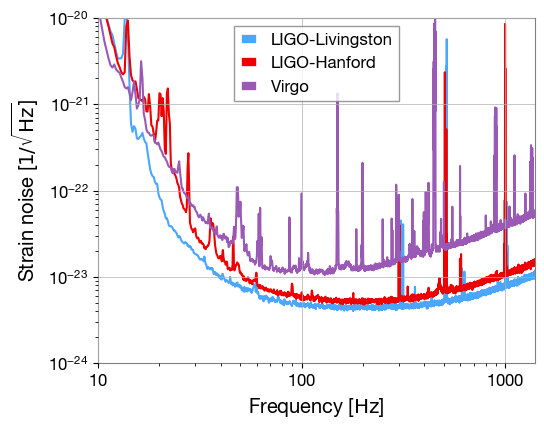

In [21]:
# get Hanford data
hdata2 = TimeSeries.fetch_open_data('H1', int(gps)-512, int(gps)+512, cache=True)
hasd2 = hdata2.asd(fftlength=4, method="median")

# get Virgo data
vdata2 = TimeSeries.fetch_open_data('V1', int(gps)-512, int(gps)+512, cache=True)
vasd2 = vdata2.asd(fftlength=4, method="median")

# and plot using standard colours
ax.plot(hasd2, label='LIGO-Hanford', color='gwpy:ligo-hanford')
ax.plot(vasd2, label='Virgo', color='gwpy:virgo')

# update the Livingston line to use standard colour, and have a label
lline = ax.lines[0]
lline.set_color('gwpy:ligo-livingston')  # change colour of Livingston data
lline.set_label('LIGO-Livingston')

ax.set_ylabel(r'Strain noise [$1/\sqrt{\mathrm{Hz}}$]')
ax.legend()
plot

Ahora podemos ver claramente la sensibilidad relativa de cada detector de LIGO y Virgo, las características comunes entre ellos, como la tendencia general en baja y alta frecuencia, y aquellas únicas de cada observatorio.

# Quizzes:

## Quiz 1:

Al observar los datos de LIGO-Livingston en el dominio del tiempo, la amplitud pico de la señal de onda gravitacional de GW190412 ocurre en el centro de la figura, es decir, aproximadamente a 5 segundos desde el inicio del segmento. Este pico es indetectable por encima del ruido de fondo a simple vista.

Realiza una representación gráfica de los datos para el detector LIGO-Hanford alrededor de GW190412. Al observar tu nueva gráfica de LIGO-Hanford, ¿puede tu ojo identificar un pico de señal? ¿Qué sucede con los datos de Virgo?

## Quiz 2 :

Calcula una Densidad Espectral de Amplitud (ASD) alrededor del tiempo del evento de O1, GW150914, para el detector L1. Compara esto con las ASD alrededor de GW190412 para el detector L1. ¿Qué datos tienen menor ruido —y por tanto son más sensibles— alrededor de 100 Hz?

